<a href="https://colab.research.google.com/github/Sumitkumar09876/BiomedNLP-HealthPredict/blob/main/Drug_Prediction_and_Polypharmacy_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cell 1: Preamble and Setup
# ---
# # Drug Prediction and Polypharmacy System with MobileBERT
# # Optimized for Google Colab

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import re
import warnings
warnings.filterwarnings('ignore')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Using device: cuda


In [3]:
# Cell 2: Data Loading and Preprocessing with Enhanced Text Representation
# ---
# ## 1. Data Loading and Preprocessing
print("Loading and preprocessing data...")

def load_data(file_path):
    """Load and preprocess the patient dataset"""
    df = pd.read_csv(file_path)

    # Clean medicine columns
    medicine_cols = ['Medicine_1', 'Medicine_2', 'Medicine_3']
    dosage_cols = ['Dosage_1', 'Dosage_2', 'Dosage_3']
    frequency_cols = ['Frequency_1', 'Frequency_2', 'Frequency_3']
    instruction_cols = ['Instruction_1', 'Instruction_2', 'Instruction_3']
    duration_cols = ['Duration_1', 'Duration_2', 'Duration_3']

    for col in medicine_cols + dosage_cols + frequency_cols + instruction_cols + duration_cols:
        if col in df.columns:
            df[col] = df[col].fillna('None')  # Fill NaN values

    # Create medication list for each patient
    df['medications'] = df.apply(
        lambda x: [med for med in [x['Medicine_1'], x['Medicine_2'], x['Medicine_3']]
                  if med != 'None' and not pd.isna(med)],
        axis=1
    )

    # Process polypharmacy risk
    df['polypharmacy_risk'] = df['Polypharmacy_Risk'].fillna('Unknown')

    # ENHANCED: Create better structured text input with clinical emphasis
    df['text_input'] = df.apply(
        lambda x: f"Patient age {x['Age']}, gender {x['Gender']}, blood group {x['Blood_Group']}, weight {x['Weight_kg']}kg. " +
                f"SYMPTOMS: {x['Symptoms']}. " +
                f"SEVERITY: {x['Severity_Scores']}. " +
                (f"HISTORY: {x['Medical_History']}. " if 'Medical_History' in df.columns and not pd.isna(x['Medical_History']) else "") +
                (f"ALLERGIES: {x['Allergies']}. " if 'Allergies' in df.columns and not pd.isna(x['Allergies']) else ""),
        axis=1
    )

    return df

# Load dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/large_patient_dataset.csv'  # Update with your file path
df = load_data(file_path)
print(f"Loaded dataset with {len(df)} patients and {df.columns.shape[0]} features")

# Display data summary
print("\nData Overview:")
print(df[['Patient_ID', 'Age', 'Gender', 'Symptoms', 'medications', 'polypharmacy_risk']].head())

# NEW: Show an example of the enhanced text representation
print("\nEnhanced Text Representation Example:")
print(df['text_input'].iloc[0])

Loading and preprocessing data...
Loaded dataset with 15000 patients and 32 features

Data Overview:
   Patient_ID  Age  Gender                                          Symptoms  \
0           1   18   Other  Chest pain; Cough; Shortness of breath; Headache   
1           2   56   Other           Headache; Dizziness; Fatigue; Back pain   
2           3   83  Female             Chest pain; Fever; Cough; Muscle pain   
3           4   57  Female            Dizziness; Headache; Nausea; Back pain   
4           5   45    Male             Runny nose; Fever; Cough; Sore throat   

                                         medications polypharmacy_risk  
0  [Albuterol Inhaler, Budesonide Inhaler, Montel...     Low to Medium  
1      [Amlodipine, Lisinopril, Hydrochlorothiazide]     Low to Medium  
2      [Amoxicillin, Guaifenesin, Albuterol Inhaler]    Medium to High  
3           [Sumatriptan, Ibuprofen, Metoclopramide]     Low to Medium  
4  [Acetaminophen, Dextromethorphan, Saline Nasal... 

In [4]:
# Cell 3: Label Encoding with Class Balance Analysis
# ---
# ## 2. Prepare labels for multi-task learning
# Medication encoding (multi-label)
mlb = MultiLabelBinarizer()
medication_labels = mlb.fit_transform(df['medications'])
medication_classes = mlb.classes_
num_medication_classes = len(medication_classes)
print(f"\nTotal unique medications: {num_medication_classes}")
print(f"Medications sample: {medication_classes[:5]}...")

# Polypharmacy risk encoding (multi-class)
le_risk = LabelEncoder()
polypharmacy_labels = le_risk.fit_transform(df['polypharmacy_risk'])
polypharmacy_classes = le_risk.classes_
num_polypharmacy_classes = len(polypharmacy_classes)
print(f"\nPolypharmacy risk categories: {polypharmacy_classes}")

# Disease encoding (multi-class)
le_disease = LabelEncoder()
disease_labels = le_disease.fit_transform(df['Predicted_Disease'])
disease_classes = le_disease.classes_
num_disease_classes = len(disease_classes)
print(f"\nTotal unique diseases: {num_disease_classes}")
print(f"Disease sample: {disease_classes[:5]}...")

# Create dictionaries for other text-based outputs
disease_causes_dict = dict(zip(df['Predicted_Disease'], df['Disease_Causes']))
disease_prevention_dict = dict(zip(df['Predicted_Disease'], df['Disease_Prevention']))
polypharmacy_recommendation_dict = dict(zip(df['polypharmacy_risk'], df['Polypharmacy_Recommendation']))

# For personalized health tips, build a model or use lookup based on disease + demographics
health_tips_dict = {}
for index, row in df.iterrows():
    key = (row['Predicted_Disease'], row['Age'] // 10 * 10, row['Gender'])  # Age binned by decade
    if key in health_tips_dict:
        health_tips_dict[key].append(row['Personalized_Health_Tips'])
    else:
        health_tips_dict[key] = [row['Personalized_Health_Tips']]

# Convert lists to most common value
for key in health_tips_dict:
    health_tips_dict[key] = max(set(health_tips_dict[key]), key=health_tips_dict[key].count)

# NEW: Data Balance Analysis
print("\n--- Class Balance Analysis ---")

# Check medication distribution
med_counts = np.sum(medication_labels, axis=0)
print(f"Medication distribution summary:")
print(f"  - Total medications: {num_medication_classes}")
print(f"  - Medications with >0 samples: {np.sum(med_counts > 0)}")
print(f"  - Most common medication: {medication_classes[np.argmax(med_counts)]}, {np.max(med_counts)} samples")
print(f"  - Least common medication: {medication_classes[np.argmin(med_counts)]}, {np.min(med_counts)} samples")
print(f"  - Zero-sample medications: {np.sum(med_counts == 0)}")

# Check polypharmacy risk distribution
risk_counts = np.bincount(polypharmacy_labels)
print(f"\nPolypharmacy risk distribution:")
for i, risk in enumerate(polypharmacy_classes):
    print(f"  - {risk}: {risk_counts[i]} samples ({risk_counts[i]/len(polypharmacy_labels)*100:.1f}%)")

# Check disease distribution
disease_counts = np.bincount(disease_labels)
print(f"\nDisease distribution (top 10):")
top_diseases = np.argsort(disease_counts)[::-1][:10]
for i in top_diseases:
    print(f"  - {disease_classes[i]}: {disease_counts[i]} samples ({disease_counts[i]/len(disease_labels)*100:.1f}%)")


Total unique medications: 27
Medications sample: ['Acetaminophen' 'Albuterol Inhaler' 'Amlodipine' 'Amoxicillin'
 'Budesonide Inhaler']...

Polypharmacy risk categories: ['Low to Medium' 'Medium to High' 'Unknown']

Total unique diseases: 5
Disease sample: ['Asthma' 'Bronchitis' 'Hypertension' 'Migraine'
 'Upper Respiratory Infection']...

--- Class Balance Analysis ---
Medication distribution summary:
  - Total medications: 27
  - Medications with >0 samples: 27
  - Most common medication: Shake well, 3601 samples
  - Least common medication: Amlodipine, 958 samples
  - Zero-sample medications: 0

Polypharmacy risk distribution:
  - Low to Medium: 3491 samples (23.3%)
  - Medium to High: 1509 samples (10.1%)
  - Unknown: 10000 samples (66.7%)

Disease distribution (top 10):
  - Upper Respiratory Infection: 3062 samples (20.4%)
  - Bronchitis: 3057 samples (20.4%)
  - Asthma: 3004 samples (20.0%)
  - Migraine: 2992 samples (19.9%)
  - Hypertension: 2885 samples (19.2%)


In [5]:
# Cell 4: Data Splitting
# ---
# ## 3. Split data
# For small datasets, we'll use a larger training portion
if len(df) < 100:
    test_size = 0.1  # Use 90% for training with small datasets
else:
    test_size = 0.2  # Default 80/20 split for larger datasets

try:
    # Try stratified split based on disease
    X_train, X_test, med_train, med_test, poly_train, poly_test, disease_train, disease_test = train_test_split(
        df['text_input'].tolist(),
        medication_labels,
        polypharmacy_labels,
        disease_labels,
        test_size=test_size,
        random_state=42,
        stratify=df['Predicted_Disease']
    )
    print(f"\nData split with stratification by disease")
except ValueError:
    # Fallback to regular split if stratification fails (e.g., too few samples per class)
    X_train, X_test, med_train, med_test, poly_train, poly_test, disease_train, disease_test = train_test_split(
        df['text_input'].tolist(),
        medication_labels,
        polypharmacy_labels,
        disease_labels,
        test_size=test_size,
        random_state=42
    )
    print(f"\nData split without stratification (regular split)")

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


Data split with stratification by disease
Training samples: 12000, Test samples: 3000


In [6]:
# Cell 5: Dataset Class
# ---
# ## 4. Create dataset class for PyTorch
class PatientDataset(Dataset):
    def __init__(self, texts, medication_labels, polypharmacy_labels, disease_labels, tokenizer, max_length=128):
        self.texts = texts
        self.medication_labels = medication_labels
        self.polypharmacy_labels = polypharmacy_labels
        self.disease_labels = disease_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        medication_label = self.medication_labels[idx]
        polypharmacy_label = self.polypharmacy_labels[idx]
        disease_label = self.disease_labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'medication_labels': torch.FloatTensor(medication_label),
            'polypharmacy_label': torch.tensor(polypharmacy_label, dtype=torch.long),
            'disease_label': torch.tensor(disease_label, dtype=torch.long)
        }

In [13]:
# Cell 6: Enhanced Model Architecture
# ---
# ## 5. Create Enhanced Multi-Task Medical Model
class EnhancedMedicationModel(nn.Module):
    def __init__(self, model_name, num_medications, num_polypharmacy_classes, num_disease_classes, dropout_rate=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        hidden_size = self.bert.config.hidden_size

        # Common representation layer
        self.common_dense = nn.Linear(hidden_size, hidden_size)

        # Task-specific layers with increased complexity
        # Medication prediction head (multi-label)
        self.medication_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size//2, num_medications)
        )

        # Polypharmacy risk head (multi-class)
        self.polypharmacy_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size//2, num_polypharmacy_classes)
        )

        # Disease prediction head (multi-class)
        self.disease_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size//2, num_disease_classes)
        )

        # Apply weight initialization
        self._init_weights()

    def _init_weights(self):
        # Initialize weights for better convergence
        for module in [self.medication_classifier, self.polypharmacy_classifier,
                      self.disease_classifier, self.common_dense]:
            if isinstance(module, nn.Sequential):
                for layer in module:
                    if isinstance(layer, nn.Linear):
                        nn.init.xavier_normal_(layer.weight)
                        nn.init.zeros_(layer.bias)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)  # Fixed: layer.bias -> module.bias

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        pooled_output = self.dropout(pooled_output)

        # Common representation
        common_features = torch.relu(self.common_dense(pooled_output))

        medication_logits = self.medication_classifier(common_features)
        polypharmacy_logits = self.polypharmacy_classifier(common_features)
        disease_logits = self.disease_classifier(common_features)

        return medication_logits, polypharmacy_logits, disease_logits

In [14]:
# Cell 7: Initialize Tokenizer and Medical-Specific Model
# ---
# ## 6. Initialize tokenizer and model
print("\nInitializing tokenizer and model...")

# Use a medical-specific model instead of MobileBERT
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"  # Medical domain-specific model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = EnhancedMedicationModel(
    model_name=model_name,
    num_medications=num_medication_classes,
    num_polypharmacy_classes=num_polypharmacy_classes,
    num_disease_classes=num_disease_classes,
    dropout_rate=0.3
)
model = model.to(device)
print(f"Model initialized: {model_name}")


Initializing tokenizer and model...
Model initialized: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract


In [15]:
# Cell 8: Create Data Loaders with Optimized Batch Size
# ---
# ## 7. Create data loaders
# Use a larger batch size since we have 15,000 samples
batch_size = 16  # Increased batch size for faster training
print(f"Using batch size: {batch_size}")

train_dataset = PatientDataset(X_train, med_train, poly_train, disease_train, tokenizer, max_length=256)  # Increased max_length
test_dataset = PatientDataset(X_test, med_test, poly_test, disease_test, tokenizer, max_length=256)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)  # Added num_workers for faster loading
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Using batch size: 16


In [16]:
# Cell 9: Loss Functions with Class Weighting and Optimizer
# ---
# ## 8. Define loss functions with class weighting and optimizer
print("Calculating class weights for imbalanced tasks...")

# For medications (multi-label)
pos_counts = np.sum(medication_labels, axis=0)
neg_counts = len(medication_labels) - pos_counts
pos_weights = torch.tensor(neg_counts / (pos_counts + 1e-5), dtype=torch.float32).to(device)

# For polypharmacy risk (multi-class)
risk_counts = np.bincount(polypharmacy_labels)
risk_weights = torch.tensor(len(polypharmacy_labels) / (risk_counts * len(risk_counts) + 1e-5), dtype=torch.float32).to(device)

# For disease (multi-class)
disease_counts = np.bincount(disease_labels)
disease_weights = torch.tensor(len(disease_labels) / (disease_counts * len(disease_counts) + 1e-5), dtype=torch.float32).to(device)

# Create weighted loss functions
medication_criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
polypharmacy_criterion = nn.CrossEntropyLoss(weight=risk_weights)
disease_criterion = nn.CrossEntropyLoss(weight=disease_weights)

# Learning rate for different layers
batch_size = 16  # Increased batch size since you have 15000 samples
lr = 3e-5
optimizer = torch.optim.AdamW([
    {'params': model.bert.parameters(), 'lr': lr * 0.1},  # Lower LR for pretrained part
    {'params': [p for n, p in model.named_parameters() if 'bert' not in n], 'lr': lr}
], weight_decay=0.01)
print(f"Using learning rate: {lr}")

# ## 9. Learning rate scheduler
num_epochs = 10
print(f"Training for {num_epochs} epochs")

total_steps = len(train_loader) * num_epochs

# Use cosine scheduler with warmup
from transformers import get_cosine_schedule_with_warmup
warmup_steps = int(total_steps * 0.1)  # Warm up for 10% of steps
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

Calculating class weights for imbalanced tasks...
Using learning rate: 3e-05
Training for 10 epochs


In [17]:
# Cell 10: Improved Training and Evaluation Functions
# ---
# ## 10. Enhanced training and evaluation functions
# For mixed precision training
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

def train_epoch(model, dataloader, optimizer, scheduler, medication_criterion,
               polypharmacy_criterion, disease_criterion, device, scaler=None):
    model.train()
    total_loss = 0
    med_losses = 0
    poly_losses = 0
    disease_losses = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        medication_labels = batch['medication_labels'].to(device)
        polypharmacy_labels = batch['polypharmacy_label'].to(device)
        disease_labels = batch['disease_label'].to(device)

        optimizer.zero_grad()

        if scaler:  # Use mixed precision if available
            with torch.cuda.amp.autocast():
                medication_logits, polypharmacy_logits, disease_logits = model(input_ids, attention_mask)

                # Calculate losses
                med_loss = medication_criterion(medication_logits, medication_labels)
                poly_loss = polypharmacy_criterion(polypharmacy_logits, polypharmacy_labels)
                disease_loss = disease_criterion(disease_logits, disease_labels)

                # Combined loss with task-specific weighting
                # For your specific imbalance, emphasize medications more
                loss = 2.0 * med_loss + 1.0 * poly_loss + 1.0 * disease_loss

            scaler.scale(loss).backward()
            # Add gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            # Forward pass
            medication_logits, polypharmacy_logits, disease_logits = model(input_ids, attention_mask)

            # Calculate losses
            med_loss = medication_criterion(medication_logits, medication_labels)
            poly_loss = polypharmacy_criterion(polypharmacy_logits, polypharmacy_labels)
            disease_loss = disease_criterion(disease_logits, disease_labels)

            # Combined loss with task-specific weighting
            loss = 2.0 * med_loss + 1.0 * poly_loss + 1.0 * disease_loss

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()
        total_loss += loss.item()
        med_losses += med_loss.item()
        poly_losses += poly_loss.item()
        disease_losses += disease_loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'med_loss': med_loss.item(),
            'poly_loss': poly_loss.item(),
            'disease_loss': disease_loss.item()
        })

    avg_loss = total_loss / len(dataloader)
    avg_med_loss = med_losses / len(dataloader)
    avg_poly_loss = poly_losses / len(dataloader)
    avg_disease_loss = disease_losses / len(dataloader)

    return avg_loss, avg_med_loss, avg_poly_loss, avg_disease_loss

def evaluate(model, dataloader, medication_criterion, polypharmacy_criterion, disease_criterion, device):
    model.eval()
    total_loss = 0
    med_losses = 0
    poly_losses = 0
    disease_losses = 0

    medication_preds_all = []
    medication_labels_all = []
    polypharmacy_preds_all = []
    polypharmacy_labels_all = []
    disease_preds_all = []
    disease_labels_all = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            medication_labels = batch['medication_labels'].to(device)
            polypharmacy_labels = batch['polypharmacy_label'].to(device)
            disease_labels = batch['disease_label'].to(device)

            # Forward pass
            medication_logits, polypharmacy_logits, disease_logits = model(input_ids, attention_mask)

            # Calculate losses
            med_loss = medication_criterion(medication_logits, medication_labels)
            poly_loss = polypharmacy_criterion(polypharmacy_logits, polypharmacy_labels)
            disease_loss = disease_criterion(disease_logits, disease_labels)
            loss = 2.0 * med_loss + 1.0 * poly_loss + 1.0 * disease_loss  # Keep weighting consistent

            total_loss += loss.item()
            med_losses += med_loss.item()
            poly_losses += poly_loss.item()
            disease_losses += disease_loss.item()

            # Get predictions
            medication_preds = torch.sigmoid(medication_logits) > 0.5
            polypharmacy_preds = torch.argmax(polypharmacy_logits, dim=1)
            disease_preds = torch.argmax(disease_logits, dim=1)

            # Collect all predictions and labels
            medication_preds_all.extend(medication_preds.cpu().numpy())
            medication_labels_all.extend(medication_labels.cpu().numpy())
            polypharmacy_preds_all.extend(polypharmacy_preds.cpu().numpy())
            polypharmacy_labels_all.extend(polypharmacy_labels.cpu().numpy())
            disease_preds_all.extend(disease_preds.cpu().numpy())
            disease_labels_all.extend(disease_labels.cpu().numpy())

    # Convert to numpy arrays
    medication_preds_all = np.array(medication_preds_all)
    medication_labels_all = np.array(medication_labels_all)
    polypharmacy_preds_all = np.array(polypharmacy_preds_all)
    polypharmacy_labels_all = np.array(polypharmacy_labels_all)
    disease_preds_all = np.array(disease_preds_all)
    disease_labels_all = np.array(disease_labels_all)

    # Calculate metrics
    medication_f1 = f1_score(medication_labels_all, medication_preds_all, average='weighted')
    polypharmacy_acc = accuracy_score(polypharmacy_labels_all, polypharmacy_preds_all)
    disease_acc = accuracy_score(disease_labels_all, disease_preds_all)

    avg_loss = total_loss / len(dataloader)
    avg_med_loss = med_losses / len(dataloader)
    avg_poly_loss = poly_losses / len(dataloader)
    avg_disease_loss = disease_losses / len(dataloader)

    return avg_loss, avg_med_loss, avg_poly_loss, avg_disease_loss, medication_f1, polypharmacy_acc, disease_acc

In [18]:
# Cell 11: Training Loop with Early Stopping
# ---
# ## 11. Enhanced training loop with early stopping
print("\nStarting training...")
history = {
    'train_loss': [], 'train_med_loss': [], 'train_poly_loss': [], 'train_disease_loss': [],
    'val_loss': [], 'val_med_loss': [], 'val_poly_loss': [], 'val_disease_loss': [],
    'med_f1': [], 'poly_acc': [], 'disease_acc': []
}

best_val_loss = float('inf')
best_med_f1 = 0.0  # Track best medication F1 score
best_model_path = 'best_medical_multitask_model.pt'
patience = 3  # Early stopping patience
early_stopping_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training
    train_loss, train_med_loss, train_poly_loss, train_disease_loss = train_epoch(
        model, train_loader, optimizer, scheduler,
        medication_criterion, polypharmacy_criterion, disease_criterion, device, scaler
    )

    history['train_loss'].append(train_loss)
    history['train_med_loss'].append(train_med_loss)
    history['train_poly_loss'].append(train_poly_loss)
    history['train_disease_loss'].append(train_disease_loss)

    print(f"Training loss: {train_loss:.4f} (Med: {train_med_loss:.4f}, Poly: {train_poly_loss:.4f}, Disease: {train_disease_loss:.4f})")

    # Evaluation
    val_loss, val_med_loss, val_poly_loss, val_disease_loss, med_f1, poly_acc, disease_acc = evaluate(
        model, test_loader, medication_criterion, polypharmacy_criterion, disease_criterion, device
    )

    history['val_loss'].append(val_loss)
    history['val_med_loss'].append(val_med_loss)
    history['val_poly_loss'].append(val_poly_loss)
    history['val_disease_loss'].append(val_disease_loss)
    history['med_f1'].append(med_f1)
    history['poly_acc'].append(poly_acc)
    history['disease_acc'].append(disease_acc)

    print(f"Validation loss: {val_loss:.4f} (Med: {val_med_loss:.4f}, Poly: {val_poly_loss:.4f}, Disease: {val_disease_loss:.4f})")
    print(f"Medication F1 score: {med_f1:.4f}")
    print(f"Polypharmacy accuracy: {poly_acc:.4f}")
    print(f"Disease prediction accuracy: {disease_acc:.4f}")

    # Save best model - prioritize medication F1 score since that's the worst performing task
    if med_f1 > best_med_f1:
        best_med_f1 = med_f1
        torch.save(model.state_dict(), best_model_path)
        print("Saved best model based on medication F1 score!")
        early_stopping_counter = 0
    elif val_loss < best_val_loss:
        best_val_loss = val_loss
        if epoch > num_epochs // 2:  # Only consider validation loss in later epochs
            torch.save(model.state_dict(), best_model_path)
            print("Saved best model based on validation loss!")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")

    # Early stopping
    if early_stopping_counter >= patience:
        print(f"Early stopping triggered after epoch {epoch+1}")
        break


Starting training...

Epoch 1/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 5.0900 (Med: 1.2179, Poly: 0.9038, Disease: 1.7505)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.9703 (Med: 0.7491, Poly: 0.1076, Disease: 1.3646)
Medication F1 score: 0.3951
Polypharmacy accuracy: 0.9680
Disease prediction accuracy: 0.3523
Saved best model based on medication F1 score!

Epoch 2/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.6497 (Med: 0.6456, Poly: 0.0727, Disease: 1.2857)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.2351 (Med: 0.5112, Poly: 0.0185, Disease: 1.1942)
Medication F1 score: 0.5390
Polypharmacy accuracy: 0.9957
Disease prediction accuracy: 0.4353
Saved best model based on medication F1 score!

Epoch 3/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.3207 (Med: 0.5460, Poly: 0.0307, Disease: 1.1980)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.2395 (Med: 0.5056, Poly: 0.0244, Disease: 1.2039)
Medication F1 score: 0.5470
Polypharmacy accuracy: 0.9947
Disease prediction accuracy: 0.4277
Saved best model based on medication F1 score!

Epoch 4/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.2587 (Med: 0.5264, Poly: 0.0222, Disease: 1.1838)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.2753 (Med: 0.5147, Poly: 0.0260, Disease: 1.2199)
Medication F1 score: 0.5469
Polypharmacy accuracy: 0.9947
Disease prediction accuracy: 0.4227

Epoch 5/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.2508 (Med: 0.5238, Poly: 0.0191, Disease: 1.1840)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.2187 (Med: 0.5040, Poly: 0.0220, Disease: 1.1888)
Medication F1 score: 0.5474
Polypharmacy accuracy: 0.9940
Disease prediction accuracy: 0.4357
Saved best model based on medication F1 score!

Epoch 6/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.2177 (Med: 0.5152, Poly: 0.0131, Disease: 1.1742)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.2130 (Med: 0.5027, Poly: 0.0159, Disease: 1.1916)
Medication F1 score: 0.5476
Polypharmacy accuracy: 0.9967
Disease prediction accuracy: 0.4263
Saved best model based on medication F1 score!

Epoch 7/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.2175 (Med: 0.5131, Poly: 0.0180, Disease: 1.1734)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.1966 (Med: 0.4998, Poly: 0.0154, Disease: 1.1816)
Medication F1 score: 0.5484
Polypharmacy accuracy: 0.9960
Disease prediction accuracy: 0.4353
Saved best model based on medication F1 score!

Epoch 8/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.2131 (Med: 0.5115, Poly: 0.0177, Disease: 1.1723)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.2013 (Med: 0.5006, Poly: 0.0162, Disease: 1.1839)
Medication F1 score: 0.5480
Polypharmacy accuracy: 0.9957
Disease prediction accuracy: 0.4387
Saved best model based on validation loss!

Epoch 9/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.2047 (Med: 0.5109, Poly: 0.0151, Disease: 1.1677)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.2004 (Med: 0.5003, Poly: 0.0162, Disease: 1.1837)
Medication F1 score: 0.5480
Polypharmacy accuracy: 0.9960
Disease prediction accuracy: 0.4377
Saved best model based on validation loss!

Epoch 10/10


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Training loss: 2.1926 (Med: 0.5076, Poly: 0.0114, Disease: 1.1661)


Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Validation loss: 2.2042 (Med: 0.5010, Poly: 0.0168, Disease: 1.1853)
Medication F1 score: 0.5479
Polypharmacy accuracy: 0.9957
Disease prediction accuracy: 0.4403
Early stopping counter: 1/3


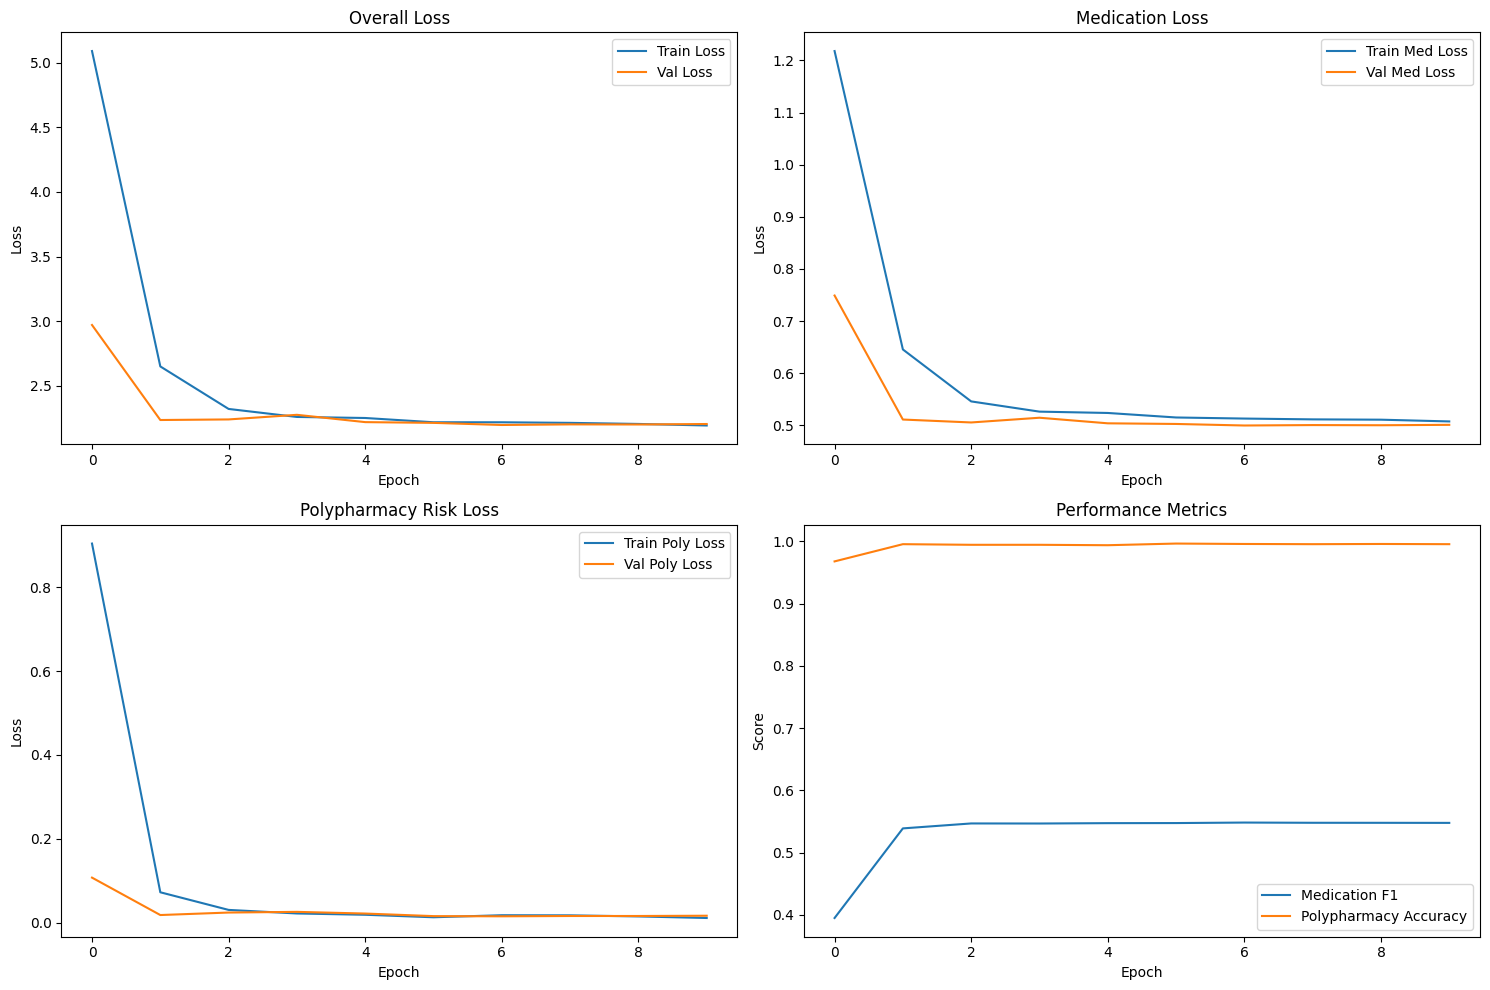

In [19]:
# Cell 12: Plot Training History
# ---
# ## 12. Plot training history
def plot_training_history(history):
    plt.figure(figsize=(15, 10))

    # Plot losses
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Overall Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history['train_med_loss'], label='Train Med Loss')
    plt.plot(history['val_med_loss'], label='Val Med Loss')
    plt.title('Medication Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(history['train_poly_loss'], label='Train Poly Loss')
    plt.plot(history['val_poly_loss'], label='Val Poly Loss')
    plt.title('Polypharmacy Risk Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot metrics
    plt.subplot(2, 2, 4)
    plt.plot(history['med_f1'], label='Medication F1')
    plt.plot(history['poly_acc'], label='Polypharmacy Accuracy')
    plt.title('Performance Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Plot training history
plot_training_history(history)

In [20]:
# Cell 13: Load Best Model
# ---
# ## 13. Load best model for inference
print("\nLoading best model for inference...")
model.load_state_dict(torch.load(best_model_path))
model.eval()


Loading best model for inference...


EnhancedMedicationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [21]:
# Cell 14: Prediction Function
# ---
# ## 14. Create a function for predictions on new data
def predict_full_health_profile(patient_data, model, tokenizer, mlb, le_risk, le_disease, device):
    """
    Make comprehensive predictions for new patient data

    Args:
        patient_data: Dictionary with patient information
        model: Trained model
        tokenizer: Tokenizer
        mlb: MultiLabelBinarizer for medications
        le_risk: LabelEncoder for polypharmacy risk
        le_disease: LabelEncoder for disease
        device: Device to run model on

    Returns:
        Dictionary with predicted disease, medications, dosages, frequencies, instructions,
        durations, polypharmacy risk, and health tips
    """
    # Create text input like during training
    text_input = f"Age: {patient_data.get('Age', '')}, Gender: {patient_data.get('Gender', '')}, " + \
                f"Blood Group: {patient_data.get('Blood_Group', '')}, Weight: {patient_data.get('Weight_kg', '')}, " + \
                f"Symptoms: {patient_data.get('Symptoms', '')}, Severity: {patient_data.get('Severity_Scores', '')}"

    # Tokenize
    encoding = tokenizer(
        text_input,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get predictions
    with torch.no_grad():
        medication_logits, polypharmacy_logits, disease_logits = model(input_ids, attention_mask)
        medication_preds = torch.sigmoid(medication_logits) > 0.5
        polypharmacy_pred = torch.argmax(polypharmacy_logits, dim=1)
        disease_pred = torch.argmax(disease_logits, dim=1)

    # Convert predictions to human-readable format
    predicted_medications = mlb.classes_[medication_preds[0].cpu().numpy()]
    predicted_risk = le_risk.classes_[polypharmacy_pred.item()]
    predicted_disease = le_disease.classes_[disease_pred.item()]

    # Get medication probabilities for all medications
    medication_probs = torch.sigmoid(medication_logits).cpu().numpy()[0]
    med_prob_dict = {med: prob for med, prob in zip(mlb.classes_, medication_probs)}

    # Sort medications by probability
    sorted_meds = sorted(med_prob_dict.items(), key=lambda x: x[1], reverse=True)
    top_meds = sorted_meds[:5]  # Get top 5 medications

    # Determine medication details from dataset based on predicted disease and medications
    # Use a lookup approach from the training data
    med_details = {}
    for i, med in enumerate(predicted_medications[:3]):  # Limit to top 3 medications
        med_idx = i + 1  # Medicine_1, Medicine_2, Medicine_3
        matching_rows = df[(df['Predicted_Disease'] == predicted_disease) &
                           (df[f'Medicine_{med_idx}'] == med)]

        if not matching_rows.empty:
            row = matching_rows.iloc[0]
            med_details[med] = {
                'dosage': row.get(f'Dosage_{med_idx}', 'Standard dosage'),
                'frequency': row.get(f'Frequency_{med_idx}', 'As directed'),
                'instruction': row.get(f'Instruction_{med_idx}', 'Follow doctor\'s advice'),
                'duration': row.get(f'Duration_{med_idx}', '7-10 days')
            }
        else:
            med_details[med] = {
                'dosage': 'Consult doctor',
                'frequency': 'Consult doctor',
                'instruction': 'Consult doctor',
                'duration': 'As prescribed'
            }

    # Get disease information
    disease_causes = disease_causes_dict.get(predicted_disease, "Unknown causes")
    disease_prevention = disease_prevention_dict.get(predicted_disease, "Consult healthcare provider")

    # Get polypharmacy recommendation
    polypharmacy_recommendation = polypharmacy_recommendation_dict.get(predicted_risk, "Consult healthcare provider")

    # Get personalized health tip based on disease and demographics
    age_decade = (patient_data.get('Age', 40) // 10) * 10
    health_tip_key = (predicted_disease, age_decade, patient_data.get('Gender', 'Other'))
    personalized_health_tip = health_tips_dict.get(
        health_tip_key,
        "Maintain a balanced diet and regular exercise routine."
    )

    # Format medication results
    med_results = []
    for i, med in enumerate(predicted_medications[:3]):
        if i < len(predicted_medications):
            med_results.append({
                'medication': med,
                'dosage': med_details[med]['dosage'],
                'frequency': med_details[med]['frequency'],
                'instruction': med_details[med]['instruction'],
                'duration': med_details[med]['duration'],
                'confidence': float(med_prob_dict[med])
            })

    # Return comprehensive results
    return {
        'predicted_disease': predicted_disease,
        'disease_causes': disease_causes,
        'disease_prevention': disease_prevention,
        'medications': med_results,
        'polypharmacy_risk': predicted_risk,
        'polypharmacy_recommendation': polypharmacy_recommendation,
        'personalized_health_tips': personalized_health_tip,
        'medication_probabilities': {med: float(prob) for med, prob in top_meds}
    }

In [22]:
# Cell 15: Sample Patient Prediction
# ---
# ## 15. Test with a sample patient
print("\nTesting with a sample patient from the dataset:")
sample_patient = {
    'Age': df['Age'].iloc[0],
    'Gender': df['Gender'].iloc[0],
    'Blood_Group': df['Blood_Group'].iloc[0],
    'Weight_kg': df['Weight_kg'].iloc[0],
    'Symptoms': df['Symptoms'].iloc[0],
    'Severity_Scores': df['Severity_Scores'].iloc[0]
}

print("\nPatient Information:")
print(f"Age: {sample_patient['Age']}")
print(f"Gender: {sample_patient['Gender']}")
print(f"Disease: {df['Predicted_Disease'].iloc[0]}")  # For reference only
print(f"Symptoms: {sample_patient['Symptoms']}")

# Get actual medications for comparison
actual_meds = [df['Medicine_1'].iloc[0], df['Medicine_2'].iloc[0], df['Medicine_3'].iloc[0]]
actual_meds = [med for med in actual_meds if med != 'None' and not pd.isna(med)]
print(f"Actual Medications: {actual_meds}")
print(f"Actual Polypharmacy Risk: {df['Polypharmacy_Risk'].iloc[0]}")

# Make prediction with new function name
prediction = predict_full_health_profile(sample_patient, model, tokenizer, mlb, le_risk, le_disease, device)

print("\nPrediction Results:")
print(f"Predicted Disease: {prediction['predicted_disease']}")
print(f"Predicted Medications: {[med['medication'] for med in prediction['medications']]}")
print("\nTop Medication Probabilities:")
for med, prob in prediction['medication_probabilities'].items():
    print(f"  {med}: {prob:.4f}")
print(f"Predicted Polypharmacy Risk: {prediction['polypharmacy_risk']}")
print(f"Polypharmacy Recommendation: {prediction['polypharmacy_recommendation']}")
print(f"\nPersonalized Health Tips: {prediction['personalized_health_tips']}")


Testing with a sample patient from the dataset:

Patient Information:
Age: 18
Gender: Other
Disease: Asthma
Symptoms: Chest pain; Cough; Shortness of breath; Headache
Actual Medications: ['Albuterol Inhaler', 'Budesonide Inhaler', 'Montelukast']
Actual Polypharmacy Risk: Low to Medium

Prediction Results:
Predicted Disease: Asthma
Predicted Medications: ['Albuterol Inhaler', 'Budesonide Inhaler', 'Montelukast']

Top Medication Probabilities:
  Albuterol Inhaler: 0.9951
  Budesonide Inhaler: 0.9913
  Montelukast: 0.9905
  Guaifenesin: 0.4305
  Amoxicillin: 0.3896
Predicted Polypharmacy Risk: Low to Medium
Polypharmacy Recommendation: Moderate risk. Follow prescribed dosage carefully.

Personalized Health Tips: nan


In [23]:
# Cell 16: Enhanced Model Performance Evaluation with Detailed Metrics
# ---
# ## 16. Create an enhanced function to evaluate model performance on all test data
def evaluate_model_performance():
    print("\nEvaluating model performance on test data...")

    # Get all test predictions
    all_predictions = []
    medication_preds_all = []
    medication_labels_all = []
    polypharmacy_preds_all = []
    polypharmacy_labels_all = []
    disease_preds_all = []
    disease_labels_all = []

    batch_idx = 0

    for batch in tqdm(test_loader, desc="Evaluating test data"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        medication_labels = batch['medication_labels']
        polypharmacy_labels = batch['polypharmacy_label']
        disease_labels = batch['disease_label']

        with torch.no_grad():
            # Get model predictions
            medication_logits, polypharmacy_logits, disease_logits = model(input_ids, attention_mask)
            medication_preds = torch.sigmoid(medication_logits) > 0.5
            polypharmacy_preds = torch.argmax(polypharmacy_logits, dim=1)
            disease_preds = torch.argmax(disease_logits, dim=1)

        # Collect predictions and labels for metrics calculation
        medication_preds_all.extend(medication_preds.cpu().numpy())
        medication_labels_all.extend(medication_labels.cpu().numpy())
        polypharmacy_preds_all.extend(polypharmacy_preds.cpu().numpy())
        polypharmacy_labels_all.extend(polypharmacy_labels.cpu().numpy())
        disease_preds_all.extend(disease_preds.cpu().numpy())
        disease_labels_all.extend(disease_labels.cpu().numpy())

        # Get predictions for each sample in batch
        for j in range(len(input_ids)):
            idx = batch_idx * batch_size + j
            if idx >= len(X_test):  # Guard against out of bounds
                break

            pred_meds = mlb.classes_[medication_preds[j].cpu().numpy()]
            pred_risk = le_risk.classes_[polypharmacy_preds[j].item()]
            pred_disease = le_disease.classes_[disease_preds[j].item()]

            # Get actual values
            actual_meds = mlb.classes_[medication_labels[j].numpy().astype(bool)]
            actual_risk = le_risk.classes_[polypharmacy_labels[j].item()]
            actual_disease = le_disease.classes_[disease_labels[j].item()]

            # Store results
            all_predictions.append({
                'Text_Input': X_test[idx],
                'Actual_Medications': actual_meds.tolist(),
                'Predicted_Medications': pred_meds.tolist(),
                'Medications_Match': set(pred_meds) == set(actual_meds),
                'Actual_Risk': actual_risk,
                'Predicted_Risk': pred_risk,
                'Risk_Match': actual_risk == pred_risk,
                'Actual_Disease': actual_disease,
                'Predicted_Disease': pred_disease,
                'Disease_Match': actual_disease == pred_disease
            })

        batch_idx += 1

    # Convert lists to arrays for metrics calculation
    medication_preds_all = np.array(medication_preds_all)
    medication_labels_all = np.array(medication_labels_all)
    polypharmacy_preds_all = np.array(polypharmacy_preds_all)
    polypharmacy_labels_all = np.array(polypharmacy_labels_all)
    disease_preds_all = np.array(disease_preds_all)
    disease_labels_all = np.array(disease_labels_all)

    # Calculate metrics
    med_accuracy = np.mean([set(p['Predicted_Medications']) == set(p['Actual_Medications']) for p in all_predictions])
    risk_accuracy = np.mean([p['Risk_Match'] for p in all_predictions])
    disease_accuracy = np.mean([p['Disease_Match'] for p in all_predictions])

    # Calculate F1 scores
    from sklearn.metrics import classification_report, precision_recall_fscore_support

    # For medication (multi-label)
    med_precision, med_recall, med_f1, _ = precision_recall_fscore_support(
        medication_labels_all,
        medication_preds_all,
        average='weighted'
    )

    # For polypharmacy and disease (multi-class)
    poly_precision, poly_recall, poly_f1, _ = precision_recall_fscore_support(
        polypharmacy_labels_all,
        polypharmacy_preds_all,
        average='weighted'
    )

    disease_precision, disease_recall, disease_f1, _ = precision_recall_fscore_support(
        disease_labels_all,
        disease_preds_all,
        average='weighted'
    )

    # Print detailed results
    print("\n----- Detailed Performance Metrics -----")
    print(f"Medication prediction accuracy: {med_accuracy:.4f}")
    print(f"Medication F1-score: {med_f1:.4f} (Precision: {med_precision:.4f}, Recall: {med_recall:.4f})")
    print(f"Polypharmacy risk prediction accuracy: {risk_accuracy:.4f}")
    print(f"Polypharmacy F1-score: {poly_f1:.4f} (Precision: {poly_precision:.4f}, Recall: {poly_recall:.4f})")
    print(f"Disease prediction accuracy: {disease_accuracy:.4f}")
    print(f"Disease F1-score: {disease_f1:.4f} (Precision: {disease_precision:.4f}, Recall: {disease_recall:.4f})")

    # Create DataFrame with results
    results_df = pd.DataFrame(all_predictions)

    return results_df

# Run evaluation
test_results = evaluate_model_performance()
print("\nSample of test results:")
print(test_results[['Actual_Disease', 'Predicted_Disease', 'Disease_Match',
                   'Actual_Medications', 'Predicted_Medications', 'Medications_Match',
                   'Actual_Risk', 'Predicted_Risk', 'Risk_Match']].head())


Evaluating model performance on test data...


Evaluating test data:   0%|          | 0/188 [00:00<?, ?it/s]


----- Detailed Performance Metrics -----
Medication prediction accuracy: 0.2177
Medication F1-score: 0.5480 (Precision: 0.4307, Recall: 0.9918)
Polypharmacy risk prediction accuracy: 0.9960
Polypharmacy F1-score: 0.9960 (Precision: 0.9961, Recall: 0.9960)
Disease prediction accuracy: 0.4377
Disease F1-score: 0.4487 (Precision: 0.6623, Recall: 0.4377)

Sample of test results:
                Actual_Disease Predicted_Disease  Disease_Match  \
0  Upper Respiratory Infection      Hypertension          False   
1                     Migraine          Migraine           True   
2                   Bronchitis            Asthma          False   
3                   Bronchitis        Bronchitis           True   
4                   Bronchitis        Bronchitis           True   

                                  Actual_Medications  \
0  [Max 200mg/day, May increase urination, Take w...   
1           [Ibuprofen, Metoclopramide, Sumatriptan]   
2      [Albuterol Inhaler, Amoxicillin, Guaifenesi

In [29]:
import sys
total_size = sum(sys.getsizeof(value) for value in model_artifacts.values())
print(f"Total size of model artifacts: {total_size} bytes")

Total size of model artifacts: 18816 bytes


In [30]:
# Cell 17: Save Model Artifacts
# ---
# ## 17. Save everything needed for deployment
print("\nSaving model artifacts for deployment...")

# Create dictionary with all model artifacts
model_artifacts = {
    'model_state_dict': model.state_dict(),
    'medication_classes': medication_classes,
    'polypharmacy_classes': polypharmacy_classes,
    'disease_classes': disease_classes,  # Added disease classes
    'model_config': {
        'model_name': model_name,
        'num_medications': num_medication_classes,
        'num_polypharmacy_classes': num_polypharmacy_classes,
        'num_disease_classes': num_disease_classes  # Added disease classes config
    },
    'training_history': history
}

torch.save(model_artifacts, 'mobileBERT_drug_prediction_model_full.pt')

# Save encoders - update to use le_risk instead of le
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump({
        'mlb': mlb,
        'le_risk': le_risk,  # Changed from 'le' to 'le_risk'
        'le_disease': le_disease  # Added disease encoder
    }, f)


Saving model artifacts for deployment...


In [31]:
# Cell 18: Prediction Interface Functions
# ---
# ## 18. Create a prediction interface function
def prepare_patient_data(age, gender, blood_group, weight_kg, symptoms, severity_scores):
    """
    Helper function to format patient data for prediction
    """
    return {
        'Age': age,
        'Gender': gender,
        'Blood_Group': blood_group,
        'Weight_kg': weight_kg,
        'Symptoms': symptoms,
        'Severity_Scores': severity_scores
    }

def predict_for_new_patient(age, gender, blood_group, weight_kg, symptoms, severity_scores):
    """
    User-friendly function to predict comprehensive health profile

    Returns:
        Dictionary with predicted disease, medications details, risk and health tips
    """
    patient_data = prepare_patient_data(
        age, gender, blood_group, weight_kg, symptoms, severity_scores
    )
    prediction = predict_full_health_profile(patient_data, model, tokenizer, mlb, le_risk, le_disease, device)
    return prediction

# Example usage
print("\nDemonstration of prediction interface:")
test_prediction = predict_for_new_patient(
    age=65,
    gender="Female",
    blood_group="A+",
    weight_kg=70.5,
    symptoms="Headache; Dizziness; Chest pain",
    severity_scores="Headache:3; Dizziness:2; Chest pain:4"
)

print("\nNew Patient Prediction:")
print(f"Predicted Disease: {test_prediction['predicted_disease']}")
print(f"Disease Causes: {test_prediction['disease_causes']}")
print(f"Disease Prevention: {test_prediction['disease_prevention']}")
print("\nRecommended Medications:")
for i, med in enumerate(test_prediction['medications']):
    print(f"  {i+1}. {med['medication']}")
    print(f"     Dosage: {med['dosage']}")
    print(f"     Frequency: {med['frequency']}")
    print(f"     Instructions: {med['instruction']}")
    print(f"     Duration: {med['duration']}")
    print(f"     Confidence: {med['confidence']:.4f}")
print(f"\nPolypharmacy Risk: {test_prediction['polypharmacy_risk']}")
print(f"Polypharmacy Recommendation: {test_prediction['polypharmacy_recommendation']}")
print(f"\nPersonalized Health Tips: {test_prediction['personalized_health_tips']}")

print("\nTraining complete! Model and artifacts saved successfully.")


Demonstration of prediction interface:

New Patient Prediction:
Predicted Disease: Migraine
Disease Causes: Common causes include various factors related to Bronchitis.
Disease Prevention: Preventive measures specific to Bronchitis and general health maintenance.

Recommended Medications:
  1. Amlodipine
     Dosage: Consult doctor
     Frequency: Consult doctor
     Instructions: Consult doctor
     Duration: As prescribed
     Confidence: 0.8132
  2. Hydrochlorothiazide
     Dosage: Consult doctor
     Frequency: Consult doctor
     Instructions: Consult doctor
     Duration: As prescribed
     Confidence: 0.8512
  3. Ibuprofen
     Dosage: Consult doctor
     Frequency: Consult doctor
     Instructions: Consult doctor
     Duration: As prescribed
     Confidence: 0.9673

Polypharmacy Risk: Low to Medium
Polypharmacy Recommendation: Moderate risk. Follow prescribed dosage carefully.

Personalized Health Tips: nan

Training complete! Model and artifacts saved successfully.


In [32]:
# Cell 19: Interactive Prediction Interface
# ---
# ## 19. Create a simple interactive prediction interface
def interactive_prediction_interface():
    """
    Simple command-line interface for making predictions
    """
    print("\n=== Drug Prediction and Polypharmacy System ===")
    print("Enter patient information to get medication recommendations and polypharmacy risk")

    age = int(input("Age: "))
    gender = input("Gender (Male/Female/Other): ")
    blood_group = input("Blood Group: ")
    weight_kg = float(input("Weight (kg): "))
    symptoms = input("Symptoms (separated by semicolons, e.g., 'Headache; Fever'): ")
    severity_scores = input("Severity Scores (format: 'Symptom:Score; Symptom:Score'): ")
    predicted_disease = input("Predicted Disease: ")

    prediction = predict_for_new_patient(
        age, gender, blood_group, weight_kg, symptoms, severity_scores, predicted_disease
    )

    print("\n=== Prediction Results ===")
    print(f"Recommended Medications:")
    for med in prediction['predicted_medications']:
        prob = prediction['medication_probabilities'].get(med, 0)
        print(f"  - {med} (Confidence: {prob:.2f})")

    print(f"\nPolypharmacy Risk: {prediction['polypharmacy_risk']}")

    if prediction['polypharmacy_risk'] in ['Medium to High', 'High']:
        print("WARNING: Higher polypharmacy risk detected. Consider medication review.")

    return prediction

In [1]:
# Cell 20: Run Interactive Interface (Main Block)
# ---
# ## 20. Run the interactive interface
# Import necessary libraries for widgets
from IPython.display import display, clear_output
import ipywidgets as widgets

# Create a function for the form-based interface
def create_prediction_widget():
    # Create input widgets
    age_widget = widgets.IntSlider(description='Age:', min=1, max=100, value=45)
    gender_widget = widgets.Dropdown(
        options=['Male', 'Female', 'Other'],
        description='Gender:',
        value='Female'
    )
    blood_group_widget = widgets.Dropdown(
        options=['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-'],
        description='Blood Group:',
        value='B+'
    )
    weight_widget = widgets.FloatText(description='Weight (kg):', value=75.0)
    symptoms_widget = widgets.Textarea(
        description='Symptoms:',
        value='Chest pain; Cough; Shortness of breath',
        layout=widgets.Layout(width='80%')
    )
    severity_widget = widgets.Textarea(
        description='Severity:',
        value='Chest pain:3; Cough:2; Shortness of breath:2',
        layout=widgets.Layout(width='80%')
    )

    output = widgets.Output()

    # Create predict button
    predict_button = widgets.Button(
        description="Predict Health Profile",
        button_style='primary',
        layout=widgets.Layout(width='50%')
    )

    # Define button click action
    def on_button_click(b):
        with output:
            clear_output()

            # Get values from widgets
            age = age_widget.value
            gender = gender_widget.value
            blood_group = blood_group_widget.value
            weight_kg = weight_widget.value
            symptoms = symptoms_widget.value
            severity_scores = severity_widget.value

            # Make prediction
            try:
                patient_data = {
                    'Age': age,
                    'Gender': gender,
                    'Blood_Group': blood_group,
                    'Weight_kg': weight_kg,
                    'Symptoms': symptoms,
                    'Severity_Scores': severity_scores
                }

                prediction = predict_full_health_profile(patient_data, model, tokenizer, mlb, le_risk, le_disease, device)

                # Display results
                print("\n=== Health Profile Prediction Results ===")
                print(f"Patient: {age} year old {gender}")
                print(f"\nPredicted Disease: {prediction['predicted_disease']}")
                print(f"Disease Causes: {prediction['disease_causes'][:100]}..." if len(prediction['disease_causes']) > 100 else f"Disease Causes: {prediction['disease_causes']}")
                print(f"Disease Prevention: {prediction['disease_prevention'][:100]}..." if len(prediction['disease_prevention']) > 100 else f"Disease Prevention: {prediction['disease_prevention']}")

                print(f"\nRecommended Medications:")
                for i, med in enumerate(prediction['medications']):
                    print(f"  {i+1}. {med['medication']} (Confidence: {med['confidence']:.2f})")
                    print(f"     Dosage: {med['dosage']}")
                    print(f"     Frequency: {med['frequency']}")
                    print(f"     Instructions: {med['instruction']}")
                    print(f"     Duration: {med['duration']}")

                print(f"\nPolypharmacy Risk: {prediction['polypharmacy_risk']}")
                print(f"Polypharmacy Recommendation: {prediction['polypharmacy_recommendation']}")

                print(f"\nPersonalized Health Tips: {prediction['personalized_health_tips']}")

            except Exception as e:
                print(f"Error making prediction: {str(e)}")
                print("Please check your inputs and try again.")

    predict_button.on_click(on_button_click)

    # Create form layout
    form = widgets.VBox([
        widgets.HBox([age_widget, gender_widget]),
        widgets.HBox([blood_group_widget, weight_widget]),
        widgets.VBox([symptoms_widget, severity_widget]),
        predict_button,
        output
    ])

    display(form)

# Run the widget interface
create_prediction_widget()